# Рекомендательные системы. Датасет MovieLens.

*Автор: Стенин Глеб Максимович*

Важные ссылки / референсы для кода и архитектуры моделей: 


*   [Базовый NCF на Kaggle](https://www.kaggle.com/code/jamesloy/deep-learning-based-recommender-systems#Evaluating-our-Recommender-System)
*   [NCF архитектура от Microsoft](https://github.com/microsoft/recommenders/blob/main/examples/02_model_collaborative_filtering/ncf_deep_dive.ipynb)
*   [Отсюда взяты некоторые метрики и интуиции](https://github.com/hse-ds/iad-applied-ds/blob/master/2023/seminars/sem09_recsys/sem09_recsys.ipynb)



# Preprocessing

## Загрузка данных

In [1]:
# Установим необходимые модули
!pip install pytorch-lightning
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Команда для аутентификации в wanbd - удобного сервиса для отслеживания обучения
!wandb login #--relogin

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Скачаем по официальной ссылке и распакуем архив
!wget https://files.grouplens.org/datasets/movielens/ml-latest.zip
!unzip /content/ml-latest.zip

Установим необходимые зависимости:

In [3]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

Обучать модель будем на GPU, если эта среда доступна, для ускорения вычислений.

In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
device

device(type='cuda', index=0)

Для обработки датасета будем использовать pandas. Из всего набора данных нам для построения модели понадобится только файл `ratings.csv` - архитектура модели, приведенная ниже позволяет добавлять иные признаки, но в условиях ограниченных вычислительных мощностей этого достаточно для базовой модели.

> У colab есть проблема с оптимизацией распакованных данных, поэтому в случае прямой загрузки датасета среда может работать медленно и фризить. Можно загрузить распакованный файл `ratings.csv` в свой Drive.

In [ ]:
ratings = pd.read_csv('/content/ml-latest/ratings.csv')

# 
# ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/misc/vk-ml/ratings.csv')

ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


## EDA

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_theme(style='whitegrid')

Построим гистограму (эмпирическая функция плотности) для рейтингов.

<Axes: xlabel='rating', ylabel='Count'>

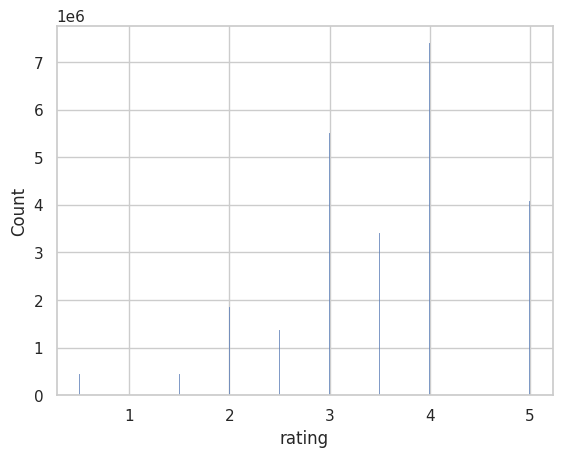

In [ ]:
sns.histplot(ratings.rating)

Распределение рейтингов имеет правостороннюю симметрию и низкий баланс классов - что может вызвать проблемы для классификации explicit признаках. В целом, консенсус в RecSys состоит в использовании implicit представлений для рейтинговых данных (см. материалы по
<a href='https://www.semanticscholar.org/paper/Collaborative-prediction-and-ranking-with-missing-Marlin-Zemel/f7ab3f31ebd8612e5c4f6a9b865b1e39c06a2345?p2df'>ссылке</a>). Подробнее в разделе [Explicit to Implicit](#scrollTo=eV9I8tA5LX2O&line=1&uniqifier=1)

In [ ]:
ratings.nunique()

userId         283228
movieId         53889
rating             10
timestamp    22131556
dtype: int64

Далее построим кумулятивную гистограмму (эмпирическую функцию распределения) для числа записей в таблице (рейтингов / взаимодействий).

In [ ]:
user_counts = np.unique(ratings.userId, return_counts=True)[1]
item_counts = np.unique(ratings.movieId, return_counts=True)[1]

<Axes: ylabel='Count'>

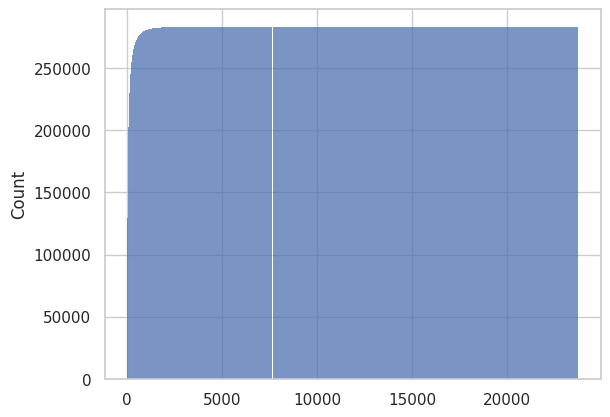

In [ ]:
sns.histplot(user_counts, cumulative=True)

<Axes: ylabel='Count'>

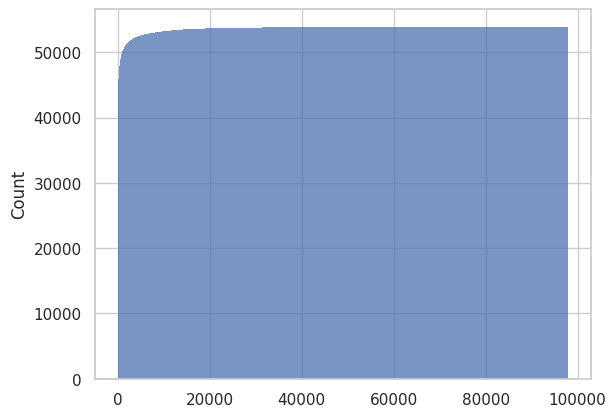

In [ ]:
sns.histplot(item_counts, cumulative=True)

Для того, чтобы исключить выбросы, будем брать пользователей и фильмы с числом рейтингов в определенном диапазоне. Для пользователей - (6, 1000), для фильмов - (6, 5000). Таким образом в обучающую выборку не попадут неактивные или аномально активные пользователи и слишком популярные или неизвестные фильмы - такие наблюдения могут искажать распределения на выходе рекомендательной модели. Также это необходимо для построения временной отложенной (тестовой) выборки в дальнейшем (для каждого пользователя нужны хотя бы 1-3 наблюдения в обучающей и тестовой выборке).

## Фильтрация

По результатам EDA проведем первичную фильтрацию данных.

In [8]:
def valid_elements(data, column, threshold=0.2):
    rating_dist = data[column].value_counts().reset_index()
    cut_off = round(threshold * rating_dist.shape[0]) + 1
    return set(rating_dist.index[cut_off:])


def get_count(data, column):
    grouped_by_column = data.groupby(column, as_index=False)
    return grouped_by_column.size()


def _filter_ratings(data, min_rating, user_count, item_count):
    if min_rating is not None:
        data = data.loc[data['rating'] >= min_rating]
    if item_count[0] > 0:
        itemcount = get_count(data, column='movieId')
        data = data.loc[
            data['movieId'].isin(itemcount.movieId[(item_count[0] <= itemcount['size']) & (itemcount['size'] <= item_count[1])])
        ]
    if user_count[0] > 0:
        usercount = get_count(data, column='userId')
        data = data.loc[
            data['userId'].isin(usercount.userId[(user_count[0] <= usercount['size']) & (usercount['size'] <= user_count[1])])
        ]
    return data


def filter_ratings(data, min_rating=0.5, user_count=(6, 1000), item_count=(6, 5000), remove_top_items=False):
    if remove_top_items:
        valid_items = valid_elements(data, column='movieId')
        data = data.loc[data['movieId'].isin(valid_items)]
    while True:
        cur_num_rows = data.shape[0]
        data = _filter_ratings(data, min_rating, user_count, item_count)
        new_num_rows = data.shape[0]
        if cur_num_rows == new_num_rows:
            break
    return data

In [ ]:
ratings_unfiltered = ratings
ratings = filter_ratings(ratings).
print(f"Before: {ratings_unfiltered.shape}; After: {ratings.shape}")

Before: (27753444, 4); After: (7338388, 4)


Выборка сократилась почти в 4 раза, однако это необходимо для корректной спецификации модели и построения временной тестовой выборки.

In [ ]:
# ratings.to_csv('ratings_filtered.csv', index=False)

Перекодируем ID для пользователей и фильмов после того, как мы удалили часть обеих групп.

In [11]:
from sklearn.preprocessing import LabelEncoder

encoder_user = LabelEncoder()
ratings.userId = encoder_user.fit_transform(ratings.userId)

encoder_item = LabelEncoder()
ratings.movieId = encoder_item.fit_transform(ratings.movieId)

In [9]:
#ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/misc/vk-ml/ratings_filtered.csv')

#ratings.head()

,userId,movieId,rating,timestamp
0,3,640,3.0,945141610
1,3,828,4.0,945141610
2,3,960,3.0,945141407
3,3,1825,3.0,945141611
4,3,1985,2.0,945141611


## Chronological Train-Test Split

Разделение выборки на тренировочную и тестовую будет производиться по временному принципу. Таким образом, в тестовой выборке мы будем предсказывать будущие (отложенные) взаимодействия пользователей по данным о прошлых взиамодействиях этих же пользователей.

In [74]:
ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)

In [75]:
ratings['rank_latest'].head()

0    4.0
1    5.0
2    6.0
3    1.0
4    2.0
Name: rank_latest, dtype: float64

In [76]:
train_mask = np.array(ratings['rank_latest'] >= 4)
test_mask = np.array(ratings['rank_latest'] <= 3)

In [77]:
np.unique(test_mask, return_counts=True)

(array([False,  True]), array([6944308,  394080]))

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7338388 entries, 31 to 27753442
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   userId       int64  
 1   movieId      int64  
 2   rating       float64
 3   timestamp    int64  
 4   rank_latest  float64
dtypes: float64(2), int64(3)
memory usage: 335.9 MB


In [ ]:
ratings_train = ratings.loc[train_mask, ['userId', 'movieId', 'rating']]
ratings_test = ratings.loc[test_mask, ['userId', 'movieId', 'rating']]

## Explicit to Implicit

Любой рейтинг будем принимать за наличие взаимодействия. Обоснования этого решения состоит в том, что задача реокмендательной системы - это выдача пользователям фильмов, которые они посмотрят. Выдача фильмов, которым они поставят высокий рейтинг - это вторичная задача, в смысле построения пайплайна - эмбеддинги в модели можно расширить и включить информацию о негативном / позитивном сентименте взаимодействия, однако рассматриваемая модель ограничена мощностями и временем. 
> Для формирования полной выборки нам понадобиться сэмлировать наблюдения, в которых **не было** взаимодействия.

In [ ]:
ratings_train.drop(columns=['rating'], inplace=True)
ratings_test.drop(columns=['rating'], inplace=True)

ratings_train['feedback'] = 1
ratings_test['feedback'] = 1

ratings_train.head()

,userId,movieId,feedback
31,0,418,1
32,0,567,1
33,0,662,1
41,0,2296,1
50,1,6,1


## Negative Sampling

Добавлять "несуществующие" наблюдения совершенно законно - мы будем их сэмплировать из всей выборки фильмов, исключая для каждого пользователя те фильмы, которые он оценил. Такая техника называется **Negative Sampling**. На каждый отзыв пользователя сгенерируем 3 негативных сэмпла (компромиссное значение - это сильно увеличивает время обучения).

In [ ]:
from tqdm import tqdm


def add_negative_sample(df_positive, negative_ratio=3):

    movie_ids = df_positive.movieId.unique()
    n_positive = len(df_positive)
    set_positive = set(zip(df_positive['userId'], df_positive['movieId']))

    dict_negative = {
        'userId': [],
        'movieId': [],
        'feedback': [],
    }

    for i in tqdm(range(n_positive)):
        users, items, labels = [], [], []
        for _ in range(negative_ratio):
            user_id = df_positive.userId.iloc[i]
            movie_id_negative = np.random.choice(movie_ids) 
            while (user_id, movie_id_negative) in set_positive:
                movie_id_negative = np.random.choice(movie_ids)
            
            dict_negative['userId'].append(user_id)
            dict_negative['movieId'].append(movie_id_negative)
            dict_negative['feedback'].append(0)

            #users.append(user_id), 
            #items.append(movie_id_negative)
            #labels.append(0)

        #np.append(dict_negative['userId'], users)
        #np.append(dict_negative['movieId'], items)
        #np.append(dict_negative['feedback'], labels)

    df_negative = pd.DataFrame(dict_negative)

    return pd.concat([df_positive, df_negative]).reset_index(drop=True)

In [ ]:
ratings_train = add_negative_sample(ratings_train, 3)

100%|██████████| 6944308/6944308 [15:44<00:00, 7349.87it/s]


In [ ]:
ratings_train.to_csv('ratings_train.csv', index=False)
ratings_test.to_csv('ratings_test.csv', index=False)

In [10]:
#ratings_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/misc/vk-ml/ratings_train.csv')
#ratings_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/misc/vk-ml/ratings_test.csv')
#ratings_train.head()

,userId,movieId,feedback
0,0,418,1
1,0,567,1
2,0,662,1
3,0,2296,1
4,1,6,1


## Batching

In [13]:
class RatingsDataset(Dataset):
    def __init__(self, ratings, device=device):
        self.len = len(ratings)
        self.users = torch.tensor(ratings.userId.values, device=device)
        self.items = torch.tensor(ratings.movieId.values, device=device)
        self.labels = torch.tensor(ratings.feedback.values, device=device)

    def __len__(self):
        return self.len
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]


In [14]:
dataset_train = RatingsDataset(ratings_train)
dataset_test = RatingsDataset(ratings_test)

In [15]:
BATCH_SIZE = 128
N_USERS = len(encoder_user.classes_)
N_ITEMS = len(encoder_item.classes_)

N_USERS, N_ITEMS

(131360, 21888)

In [16]:
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

# Метрики

В качестве метрик обучения будем использовать метрики ранжирования - mnAP@k (normalized mean average precision at k) и nDCG@k (normalized DCG at k).

In [19]:
def prepare_target(output: torch.Tensor, target: torch.Tensor):
    indices = output.argsort(dim=-1, descending=True)
    sorted_target = torch.gather(target, index=indices, dim=-1)
    return sorted_target


def nan_to_num(tensor: torch.Tensor, nan: float = 0.0):
    return torch.where(
        torch.isnan(tensor) | torch.isinf(tensor),
        torch.full_like(tensor, fill_value=nan),
        tensor,
    )

def MNAP(output: torch.Tensor, target: torch.Tensor, k: int, normalized: bool = True):

    k = min(output.size(-1), k)
    target_sorted_by_output = prepare_target(output, target)[:, :k]
    target_cumsum = target_sorted_by_output.cumsum(dim=-1)
    k_tensor = torch.arange(0, k, dtype=torch.long, device=output.device)
    precisions = target_cumsum / (k_tensor + 1.0)
    relevant_precisions = precisions * target_sorted_by_output

    denominator = (
        target.sum(dim=-1).clamp(max=k)
        if normalized
        else target_sorted_by_output.sum(dim=-1)
    )

    ap_score = nan_to_num(relevant_precisions.sum(dim=-1) / denominator)

    return ap_score.mean()


def DCG(tensor: torch.Tensor):
    gains = (2**tensor) - 1
    return gains / torch.log2(
        torch.arange(0, tensor.size(-1), dtype=torch.float, device=tensor.device) + 2.0
    )



def NDCG(output: torch.Tensor, target: torch.Tensor, k: int):
    
    k = min(output.size(-1), k)
    target_sorted_by_output = prepare_target(output, target)
    ideal_target = prepare_target(target, target)
    ideal_dcg = DCG(ideal_target)[:, :k]
    prediction_dcg = DCG(target_sorted_by_output)[:, :k]
    ideal_dcg_score = ideal_dcg.sum(dim=-1)

    prediction_dcg_score = prediction_dcg.sum(dim=-1)
    ndcg_score = nan_to_num(prediction_dcg_score / ideal_dcg_score)

    return ndcg_score.mean()

# Модель NCF (Neural Collaborative Filtering)

In [56]:
class NCFModule(pl.LightningModule):
    
    def __init__(self, n_users, n_items, emb_dim=8, lr=3e-4, weight_decay=1e-3):
        super().__init__()
        
        self.save_hyperparameters()

        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.lr = lr
        self.weight_decay = weight_decay

        self.user_emb_mlp = nn.Embedding(num_embeddings=n_users, embedding_dim=emb_dim)
        self.item_emb_mlp = nn.Embedding(num_embeddings=n_items, embedding_dim=emb_dim)
        self.user_emb_gmf = nn.Embedding(num_embeddings=n_users, embedding_dim=emb_dim)
        self.item_emb_gmf = nn.Embedding(num_embeddings=n_items, embedding_dim=emb_dim)

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
        )

        self.gmf = nn.Sequential(
            nn.Linear(emb_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
        )

        self.clf = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(8, 2),
        )

        self.loss = nn.CrossEntropyLoss()
        self.metric = MNAP

        
    def forward(self, user_batch, item_batch):
        
        user_batch_mlp = self.user_emb_mlp(user_batch)
        item_batch_mlp = self.item_emb_mlp(item_batch)

        mlp_input = torch.cat([user_batch_mlp, item_batch_mlp], dim=-1)
        mlp_output = self.mlp(mlp_input)

        user_batch_gmf = self.user_emb_gmf(user_batch)
        item_batch_gmf = self.item_emb_gmf(item_batch)

        gmf_input = torch.mul(user_batch_gmf, item_batch_gmf)
        gmf_output = self.gmf(gmf_input)

        clf_input = torch.cat([mlp_output, gmf_output], dim=-1)
        clf_output = self.clf(clf_input)

        return clf_output

    
    def training_step(self, batch, batch_idx):
        user_batch, item_batch, labels_true = batch

        logits = self.forward(user_batch, item_batch)
        loss = self.loss(logits, labels_true)

        labels_true_enc = nn.functional.one_hot(labels_true, num_classes=2)
        metric = MNAP(logits, labels_true_enc, k=3)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_mnap', metric, on_step=False, on_epoch=True, prog_bar=True)  

        return loss


    def validation_step(self, batch, batch_idx):
        if trainer.global_step == 0: 
            wandb.define_metric('test_mnap', summary='max')

        user_batch, item_batch, labels_true = batch

        logits = self.forward(user_batch, item_batch)
        loss = self.loss(logits, labels_true)

        labels_true_enc = nn.functional.one_hot(labels_true, num_classes=2)
        metric = MNAP(logits, labels_true_enc, k=3)

        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_mnap', metric, on_step=False, on_epoch=True, prog_bar=True)  

        return loss

    def test_step(self, batch, batch_idx):
        user_batch, item_batch, labels_true = batch

        logits = self.forward(user_batch, item_batch)
        loss = self.loss(logits, labels_true)

        labels_true_enc = nn.functional.one_hot(labels_true, num_classes=2)
        mnap_list = [(k, MNAP(logits, labels_true_enc, k=k)) for k in [1, 3, 5, 10]]
        ndcg_list = [(k, NDCG(logits, labels_true_enc, k=k)) for k in [1, 3, 5, 10]]


        self.log('test_loss', loss)
        [self.log(f'test_mnap@{k}', mnap) for k, mnap in mnap_list]
        [self.log(f'test_ndcg@{k}', ndcg) for k, ndcg in ndcg_list]

        return loss


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        lr_lambda = lambda step: 0.1 ** step
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

        lr_scheduler = {
            'scheduler': scheduler,
            'name': 'learning_rate',
            'monitor': 'test_mnap',
            'interval': 'step',
            'frequency': 10000,
        }

        return [optimizer], [lr_scheduler]  

In [51]:
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

In [34]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [58]:
model_config = {
    'n_users': N_USERS,
    'n_items': N_ITEMS, 
    'emb_dim': 8,
    'lr': 1e-5, 
    'weight_decay': 1e-3,
}

config = {
    'model': 'NCF',
    **model_config,
}

In [53]:
str(device)

'cuda:0'

Соберем модель и запустим обучения. Будем подбирать гиперпараметры с помощью экспериментов в wandb и отслеживания метрик.

In [ ]:
wandb.finish()

wandb_logger = WandbLogger(project='vk-movielens', config=config, log_model='all')
checkpoint_callback = ModelCheckpoint(monitor='test_mnap', mode='max', save_top_k=1)
lr_monitor = LearningRateMonitor(logging_interval='step')

model = NCFModule(**model_config).to(device)

trainer = pl.Trainer(
    accelerator='cuda', 
    max_epochs=10, 
    gradient_clip_val=1,
    logger=wandb_logger, 
    callbacks=[checkpoint_callback, lr_monitor]
) 

trainer.fit(model, dataloader_train, dataloader_test)

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,▁
train_loss_step,▇▆▇▇▇▆▆▆█▇▆▆▆▆▇▆▆▅▅▆▅▅▄▅▅▃▃▆▅▃▂▃▁▃▃▃█▄▂▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,0
learning_rate,1e-05
train_loss_step,0.59292
trainer/global_step,5949


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | user_emb_mlp | Embedding        | 1.1 M 
1 | item_emb_mlp | Embedding        | 175 K 
2 | user_emb_gmf | Embedding        | 1.1 M 
3 | item_emb_gmf | Embedding        | 175 K 
4 | mlp          | Sequential       | 3.8 K 
5 | gmf          | Sequential       | 952   
6 | clf          | Sequential       | 154   
7 | loss         | CrossEntropyLoss | 0     
--------------------------------------------------
2.5 M     Trainable params
0         N

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [55]:
trainer.test(model, dataloader_test)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.3731818199157715     │
│        test_mnap@1        │            0.0            │
│       test_mnap@10        │            0.5            │
│        test_mnap@3        │            0.5            │
│        test_mnap@5        │            0.5            │
│        test_ndcg@1        │            0.0            │
│       test_ndcg@10        │    0.6309507489204407     │
│        test_ndcg@3        │    0.6309507489204407     │
│        test_ndcg@5        │    0.6309507489204407     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.3731818199157715,
  'test_mnap@1': 0.0,
  'test_mnap@3': 0.5,
  'test_mnap@5': 0.5,
  'test_mnap@10': 0.5,
  'test_ndcg@1': 0.0,
  'test_ndcg@3': 0.6309507489204407,
  'test_ndcg@5': 0.6309507489204407,
  'test_ndcg@10': 0.6309507489204407}]

[Ссылка на репорт обучения в wandb](https://wandb.ai/halaction/vk-movielens)